<a href="https://colab.research.google.com/github/holinesspurba/image_clasification/blob/master/test_lagi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import shutil
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2

In [2]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# Path dataset
data_dir = '/content/drive/MyDrive/skripsi/seven_plastics'
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')

# Split 80-20 untuk train-val
split_ratio = 0.8
for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path) and 'train' not in class_name and 'val' not in class_name:
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

        images = os.listdir(class_path)
        random.shuffle(images)

        split_idx = int(len(images) * split_ratio)
        train_images = images[:split_idx]
        val_images = images[split_idx:]

        for img in train_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_name))

        for img in val_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(val_dir, class_name))

print("\n✅ Dataset berhasil dipisah ke train/ dan val/")

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=45,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.4,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255)

# Load train dan val set
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Cek jumlah kelas
print("✅ Class indices:", train_generator.class_indices)
num_classes = len(train_generator.class_indices)


Mounted at /content/drive

✅ Dataset berhasil dipisah ke train/ dan val/
Found 1219 images belonging to 8 classes.
Found 309 images belonging to 8 classes.
✅ Class indices: {'HDPE': 0, 'LDPE': 1, 'NoPlastic': 2, 'OTHER': 3, 'PET': 4, 'PP': 5, 'PS': 6, 'PVC': 7}


In [12]:
from sklearn.utils.class_weight import compute_class_weight
from tensorflow import keras

# Hitung class weights
labels = train_generator.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

class_weight_dict = dict(enumerate(class_weights))
print("✅ Class Weights:", class_weight_dict)

@keras.utils.register_keras_serializable()
# Capsule Layer
class CapsuleLayer(layers.Layer):
    def __init__(self, num_capsules, dim_capsules, routings=3, **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsules = num_capsules
        self.dim_capsules = dim_capsules
        self.routings = routings

    def build(self, input_shape):
        self.W = self.add_weight(
            shape=[input_shape[-1], self.num_capsules * self.dim_capsules],
            initializer='glorot_uniform',
            trainable=True,
            name='capsule_weight'
        )

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        u_hat = tf.matmul(inputs, self.W)
        u_hat = tf.reshape(u_hat, [batch_size, self.num_capsules, self.dim_capsules])

        squash_norm = tf.norm(u_hat, axis=-1, keepdims=True)
        squash_factor = tf.square(squash_norm) / (1 + tf.square(squash_norm)) / (squash_norm + 1e-9)
        output = squash_factor * u_hat

        return output

    def get_config(self):
        config = super(CapsuleLayer, self).get_config()
        config.update({
            'num_capsules': self.num_capsules,
            'dim_capsules': self.dim_capsules,
            'routings': self.routings,
        })
        return config

# Build Hybrid Model
def build_hybrid_model(input_shape, num_classes):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False

    x = layers.GlobalAveragePooling2D()(base_model.output)

    caps_layer = CapsuleLayer(num_capsules=num_classes, dim_capsules=16)(x)
    caps_output = layers.Flatten()(caps_layer)

    x = layers.Dense(128, activation='relu')(caps_output)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=base_model.input, outputs=outputs)
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

input_shape = (224, 224, 3)
model = build_hybrid_model(input_shape, num_classes)
model.summary()


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr]
)

model.save('/content/drive/MyDrive/skripsi/seven_plastics/trained_model.keras')
print("✅ Model disimpan di trained_model.keras")


✅ Class Weights: {0: np.float64(1.0730633802816902), 1: np.float64(1.002467105263158), 2: np.float64(1.0655594405594406), 3: np.float64(1.1543560606060606), 4: np.float64(0.8560393258426966), 5: np.float64(0.7432926829268293), 6: np.float64(1.3135775862068966), 7: np.float64(1.0091059602649006)}


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,439,368 (9.31 MB)

 Trainable params: 181,384 (708.53 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 111s 3s/step - accuracy: 0.1233 - loss: 2.0793 - val_accuracy: 0.3430 - val_loss: 1.9834 - learning_rate: 1.0000e-04
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.2479 - loss: 1.9961 - val_accuracy: 0.4272 - val_loss: 1.8953 - learning_rate: 1.0000e-04
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.3406 - loss: 1.9059 - val_accuracy: 0.4660 - val_loss: 1.8219 - learning_rate: 1.0000e-04
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.3858 - loss: 1.8348 - val_accuracy: 0.4757 - val_loss: 1.7566 - learning_rate: 1.0000e-04
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.3822 - loss: 1.7767 - val_accuracy: 0.4725 - val_loss: 1.7003 - learning_rate: 1.0000e-04
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.4062 - loss: 1.7343 - val_accuracy: 0.5178 - val_loss: 1.6428 - learning_rate: 1.0000e-04
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.4185 - loss

10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step


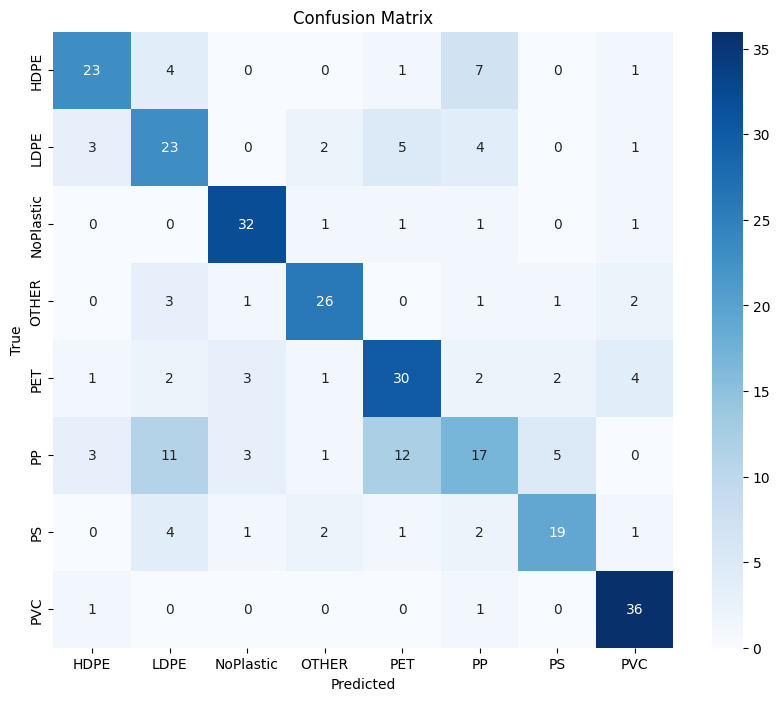


Classification Report:
              precision    recall  f1-score   support

        HDPE       0.74      0.64      0.69        36
        LDPE       0.49      0.61      0.54        38
   NoPlastic       0.80      0.89      0.84        36
       OTHER       0.79      0.76      0.78        34
         PET       0.60      0.67      0.63        45
          PP       0.49      0.33      0.39        52
          PS       0.70      0.63      0.67        30
         PVC       0.78      0.95      0.86        38

    accuracy                           0.67       309
   macro avg       0.67      0.68      0.67       309
weighted avg       0.66      0.67      0.66       309



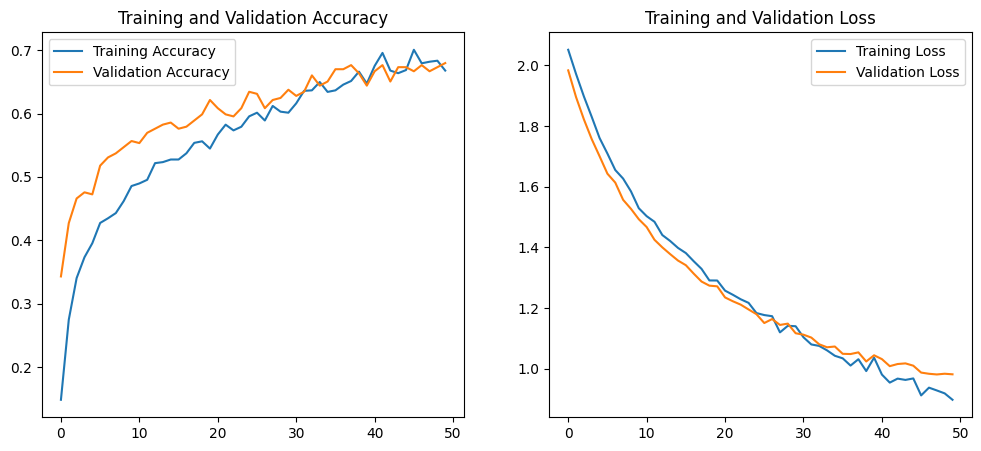

In [13]:
# Prediksi di validation set
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))


# Plot Accuracy dan Loss
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


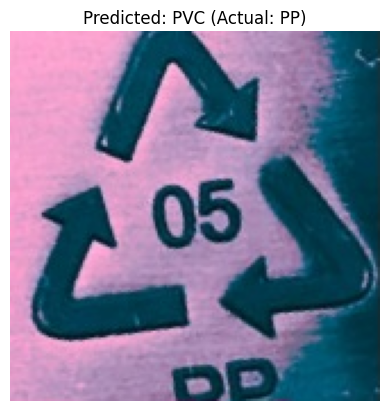

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


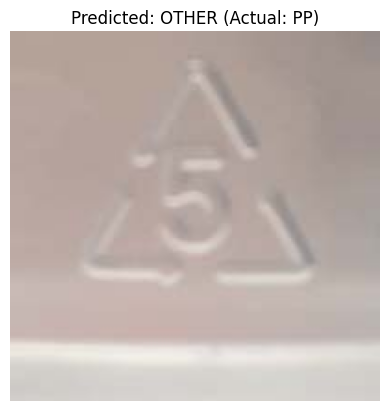

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


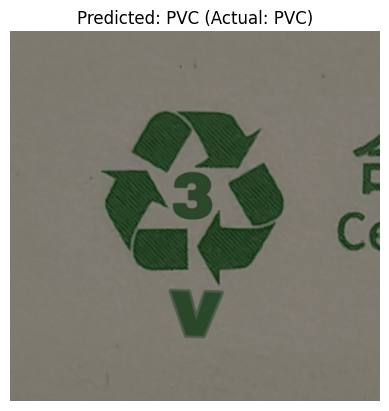

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


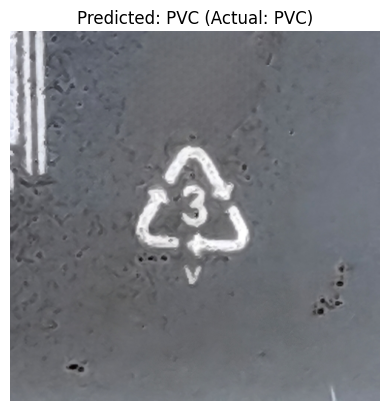

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


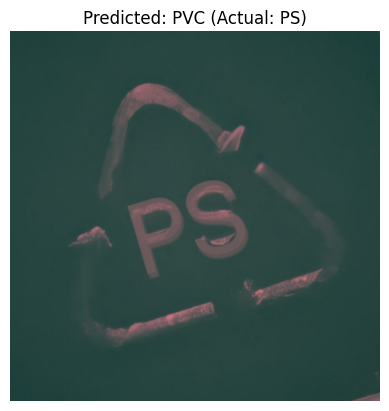

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


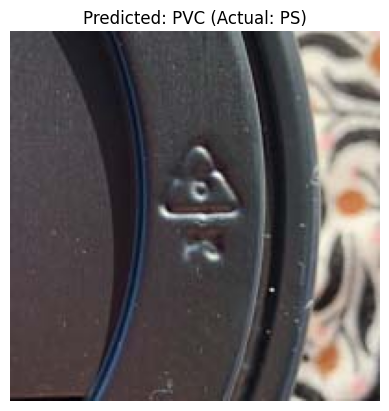

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


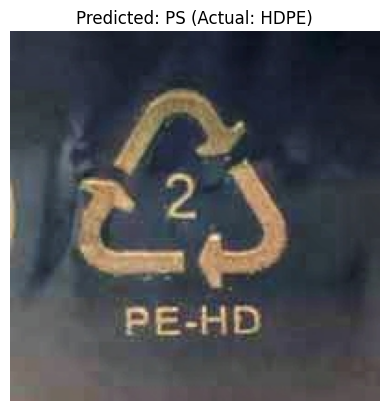

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


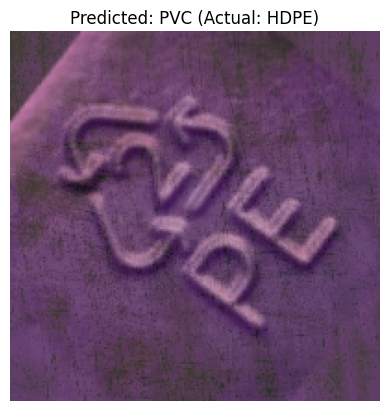

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


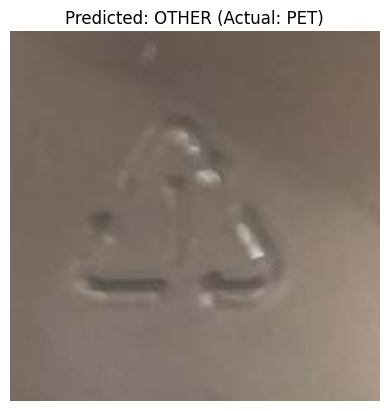

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


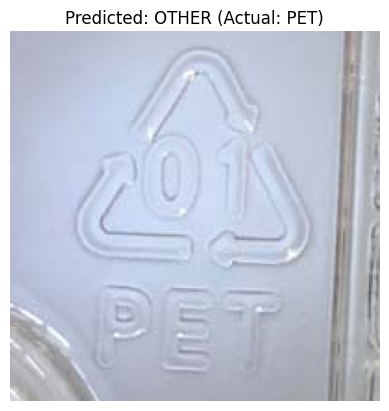

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


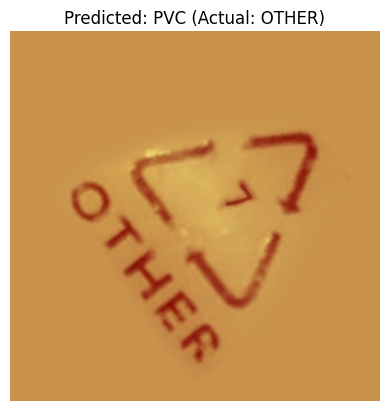

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


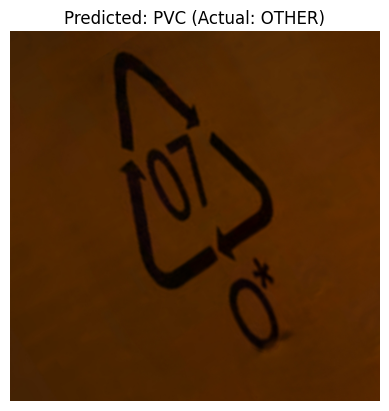

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


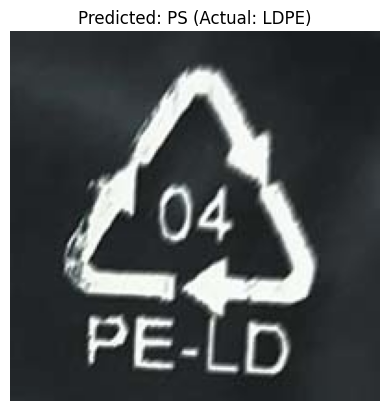

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


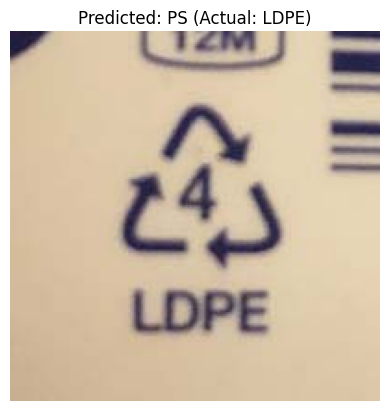

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


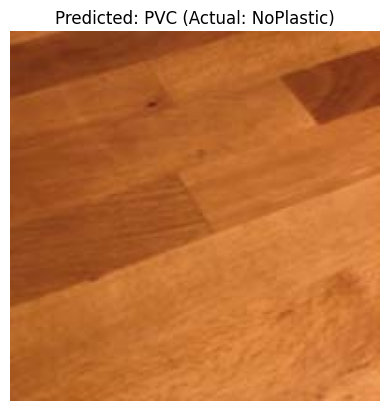

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


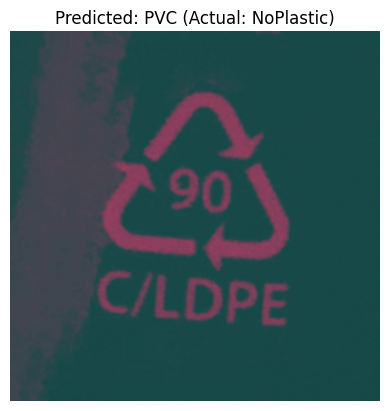

In [14]:

def display_and_test_image(image_path, model, class_labels):
    # Added class_labels as an argument for flexibility
    img = mpimg.imread(image_path)
    img_resized = tf.image.resize(img, [224, 224]) # Resize using tf.image.resize
    img_array = np.expand_dims(img_resized, axis=0)  # Add batch dimension

    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)
    predicted_class_name = class_labels[predicted_class_index]

    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class_name} (Actual: {os.path.basename(os.path.dirname(image_path))})")
    # Display actual and predicted class
    plt.axis('off')
    plt.show()

# Get class labels from your validation generator
class_labels = list(val_generator.class_indices.keys())

for class_name in os.listdir(val_dir):
    class_path = os.path.join(val_dir, class_name)
    if os.path.isdir(class_path):
        image_names = os.listdir(class_path)
        random_images = random.sample(image_names, 2)  # Select 2 random images

        for image_name in random_images:
            image_path = os.path.join(class_path, image_name)
            display_and_test_image(image_path, model, class_labels)

In [16]:
model = tf.keras.models.load_model('/content/drive/MyDrive/skripsi/seven_plastics/trained_model.keras')
# Konversi ke TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan model TFLite
with open('/content/drive/MyDrive/skripsi/seven_plastics/trained_model.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpi1trgcsb'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  133463434363920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133463434365264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133463434365648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133463434365456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133463434364112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133463434363728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133463434367568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133463434367952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133463434367760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133463434364496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1334634343691